In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
df = pd.read_csv("data/medical_insurance.csv", sep=",")
df = df.drop_duplicates()

In [5]:
le_smoker = LabelEncoder()
df["smoker"] = le_smoker.fit_transform(df["smoker"])

le_sex = LabelEncoder()
df["sex"] = le_sex.fit_transform(df["sex"])

oh_region = OneHotEncoder()
encoded_region = oh_region.fit_transform(df[["region"]])
encoded_region = pd.DataFrame(encoded_region.toarray(), columns=["northeast", "northwest", "southeast", "southwest"])
df.drop(columns=["region"], inplace=True)
df = pd.merge(df, encoded_region, left_index=True, right_index=True)

/home/g/anaconda3/envs/sy09/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/g/anaconda3/envs/sy09/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/g/anaconda3/envs/sy09/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


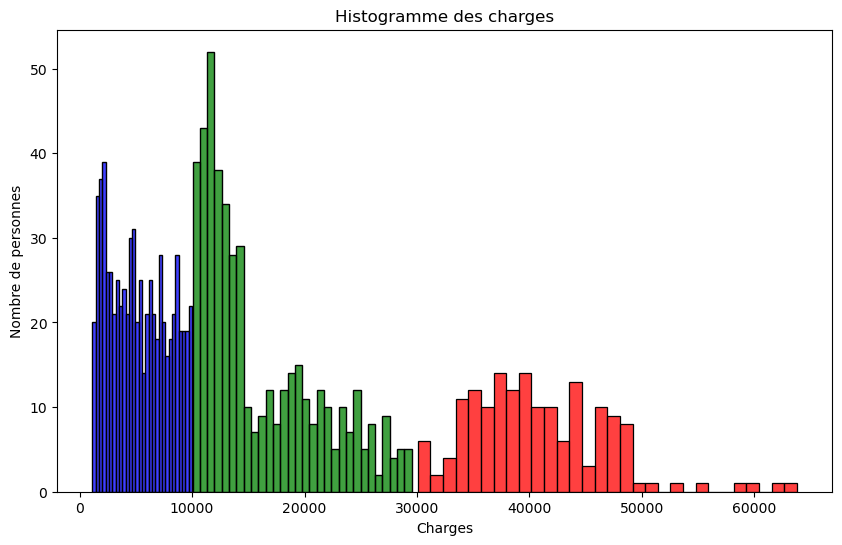

Nombre de personnes avec des charges < 10000 :  711
Nombre de personnes avec des charges entre 10000 et 30000 :  463
Nombre de personnes avec des charges > 30000 :  162


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df["charges"] < 10000]["charges"], color="blue", bins=30)
sns.histplot(df[(df["charges"] >= 10000) & (df["charges"] <= 30000)]["charges"], color="green", bins=30)
sns.histplot(df[df["charges"] > 30000]["charges"], color="red", bins=30)
plt.xlabel("Charges")
plt.ylabel("Nombre de personnes")
plt.title("Histogramme des charges")
plt.show()
# On affiche le nombre de chaque groupe
print("Nombre de personnes avec des charges < 10000 : ", len(df[df["charges"] < 10000]))
print("Nombre de personnes avec des charges entre 10000 et 30000 : ", len(df[(df["charges"] >= 10000) & (df["charges"] <= 30000)]))
print("Nombre de personnes avec des charges > 30000 : ", len(df[df["charges"] > 30000]))

In [7]:
# On tente de prédire les coûts d'assurance en fonction des autres variables
# En trois groupes : 0-10000, 10000-30000, >30000
df['charges_group'] = pd.cut(df['charges'], bins=[0, 10000, 30000, np.inf], labels=[0, 1, 2])

# On enlève la variable charges
df = df.drop(columns=['charges'])

Text(0.5, 1.0, 'Charges group en fonction de PCA 1 et PCA 2')

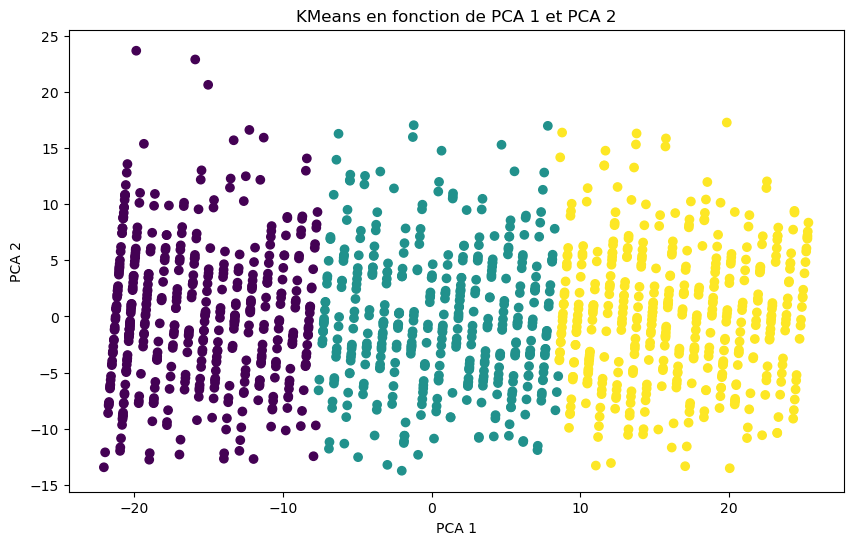

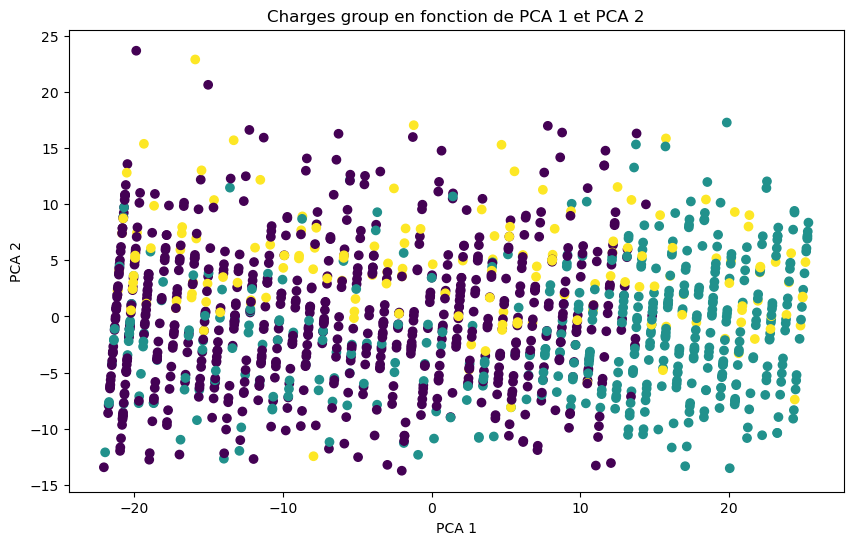

In [15]:
# cluster sur bmi age et children  vers charge cat
x = df.drop(columns=["charges_group"])
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=3, init="random")
cls.fit(x)

# sub plot pgraph 1 avec en couleur le kmeans en fct de pca 1 et 2, graph 2 couleur charges group en fct pca 1 et 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cls.labels_)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans en fonction de PCA 1 et PCA 2")

plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df["charges_group"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Charges group en fonction de PCA 1 et PCA 2")




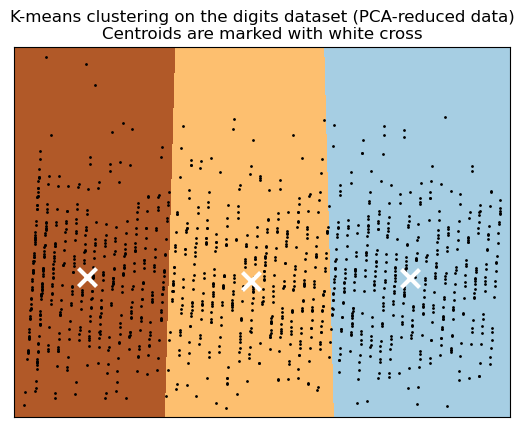

In [17]:
import matplotlib.pyplot as plt

x = df.drop(columns=["charges_group"])
y = df["charges_group"]
n_digits= 3

reduced_data = PCA(n_components=2).fit_transform(x)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [25]:
# Nearest kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(columns=['charges_group'])
y = df['charges_group']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
# On prédit les valeurs
y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.75


In [27]:
# On regarde les valeurs prédites pour être sûr qu'il ne prédit pas toujours la même chose
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([198,  63,   7], dtype=int64))

In [28]:
# On compare différents algorithmes de classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

models = [LogisticRegression(), SVC(), RandomForestClassifier(), DecisionTreeClassifier()]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, accuracy_score(y_test, y_pred))

c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() 0.8283582089552238
SVC() 0.6977611940298507
RandomForestClassifier() 0.9029850746268657
DecisionTreeClassifier() 0.8656716417910447


In [29]:
# On regarque ce que réponds le RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([164,  79,  25], dtype=int64))

In [30]:
# On peut voir que le RandomForestClassifier est le meilleur modèle pour prédire les coûts d'assurance
# On va maintenant faire du random grid search pour trouver les meilleurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['log2', 'sqrt', 'int', 'auto']

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
153 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
46 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c

{'n_estimators': 277, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}


Meilleurs paramètres pour le modèle de régression logistique : 
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

In [31]:
# Paramètres optimaux : {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9104477611940298


In [53]:
# On tente de prédire les coûts d'assurance en fonction des autres variables pour un individu saisit par l'utilisateur
age = int(input("Entrez l'âge de la personne : "))
sex = input("Entrez le sexe de la personne (h : Homme, f : Femme) : ") == "h"
smoker = input("Est-ce que la personne fume (o : Oui, n : Non) : ") == "o"
bmi = float(input("Entrez l'IMC de la personne : "))
children = int(input("Entrez le nombre d'enfants de la personne : "))
region = input("Entrez la région de la personne (ne : Northeast, nw : Northwest, se : Southeast, sw : Southwest) : ")

In [54]:
data = {
    'age': age,
    'sex': sex,
    'bmi': bmi,
    'children': children,
    'smoker': smoker,
    'northeast': region == 'ne' or region == 'NE' or region == 'Ne' or region == 'nE',
    'northwest': region == 'NW' or region == 'nw' or region == 'Nw' or region == 'nW',
    'southeast': region == 'SE' or region == 'se' or region == 'Se' or region == 'sE',
    'southwest': region == 'SW' or region == 'sw' or region == 'Sw' or region == 'sW'
}

input_df = pd.DataFrame(data, index=[0])
input_df

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest
0,21,True,21.0,0,True,False,False,False,True


In [55]:
# On prédit les coûts d'assurance
model.predict(input_df)
if model.predict(input_df) == 0:
    print("Le coût d'assurance de cette personne est inférieur à 10000")
elif model.predict(input_df) == 1:
    print("Le coût d'assurance de cette personne est compris entre 10000 et 30000")
else:
    print("Le coût d'assurance de cette personne est supérieur à 30000")

Le coût d'assurance de cette personne est compris entre 10000 et 30000
